In [ ]:
from IPython.display import HTML
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
import seaborn as sns
mpl.rc('image', cmap='gray')
%matplotlib inline

import pySPM as spm
import trackpy as tp

# STM video analysis

This notebook will walk you through how to load and analyze STM image data with a focus on calculating dynamical quantities such as diffusion coefficient and drift velocity.  All analysis are built around <a href=https://soft-matter.github.io/trackpy/v0.5.0/index.html>TrackPy</a> and <a href=https://github.com/scholi/pySPM>pySPM</a> libraries. Since analysis primarly revolves around using Trackpy, it may be useful to go through their <a href=https://soft-matter.github.io/trackpy/v0.5.0/tutorial/walkthrough.html>basic walkthrough of the library</a>.



First we have to choose which images we want to analyze.  For our video studies, we typically take a series of images (~15 frames) before changing either the voltage or temperature in our system.

For example, take 3 frames per temperature starting at `Image_001.sxm` for 2 temperatures 15K and 16K.  That means

15K : `Image_001.sxm`, `Image_002.sxm`, `Image_003.sxm`

16K : `Image_004.sxm`, `Image_005.sxm`, `Image_006.sxm`

When we load data into our analysis, software we just need to pass in a list of numerical ranges corresponding to the filepaths for the frames taken at a particular voltage/temperature.  Below is one such code to generate such a list.

In [64]:
def get_frames(foldername, setrange):
    filepaths = [rootpath+foldername+"/Image_{0:03}.sxm".format(i) for i in range(setrange[0], setrange[1]+1)]
    files = [spm.SXM(file) for file in filepaths]
    minshape = 9999999
    zdata = np.array([f.get_channel("Z").correct_plane().pixels for f in files])
    min_z = np.min(zdata)
    max_z = np.max(zdata)
    zdata -= min_z
    zdata /= max_z - min_z
    zdata_params = {
        'frame_len': len(zdata),
        'frame_dtype': zdata.dtype,
        'frame_shape': zdata[0].shape,
        'frame_size': files[0].size,
        'meters_per_pixel': (files[0].size['real']['x']/files[0].size['pixels']['x'])
    }
    print(f'{len(zdata)} frames [shape={zdata[0].shape}] retrieved')        
    return zdata, zdata_params

rootpath = './'
#foldername = 'electromigration_33'
foldername = 'electromigration_19'
setrange = [776, 790]  # [first frame no., last frame no.]
frames, frame_params = get_frames(foldername, setrange)
#-20Vg
Vg = -20
voltages_temperatures = np.linspace(0.44, 0.72, 8, np.float32)
frames

15 frames [shape=(192, 192)] retrieved


array([[[0.39175777, 0.37234632, 0.37543887, ..., 0.56578058,
         0.58429899, 0.57555234],
        [0.36073213, 0.37325159, 0.38977034, ..., 0.53757985,
         0.55670132, 0.59661279],
        [0.35243266, 0.34812968, 0.34223967, ..., 0.56816244,
         0.54195854, 0.55295446],
        ...,
        [0.27430043, 0.30208704, 0.27334391, ..., 0.19100335,
         0.19317542, 0.18195302],
        [0.2884732 , 0.29350191, 0.28116859, ..., 0.17391178,
         0.19389024, 0.20161689],
        [0.33546561, 0.28818605, 0.28521616, ..., 0.2122073 ,
         0.20212755, 0.18630278]],

       [[0.07285408, 0.04632732, 0.04985876, ..., 0.26285791,
         0.2597556 , 0.2514796 ],
        [0.07755714, 0.04001644, 0.06383004, ..., 0.24597745,
         0.26874362, 0.25037415],
        [0.06356507, 0.07122278, 0.0530755 , ..., 0.24969656,
         0.24760995, 0.25333149],
        ...,
        [0.24239848, 0.22428293, 0.22311679, ..., 0.13613687,
         0.14189015, 0.11888658],
        [0.2

In [37]:
frames

array([[[0.38437236, 0.36544311, 0.36845883, ..., 0.55407235,
         0.57213075, 0.56360137],
        [0.35411742, 0.36632589, 0.38243431, ..., 0.52657214,
         0.54521863, 0.58413868],
        [0.34602412, 0.34182802, 0.33608432, ..., 0.55639505,
         0.53084206, 0.54156484],
        ...,
        [0.26983273, 0.29692911, 0.26889997, ..., 0.1886048 ,
         0.19072291, 0.17977928],
        [0.28365344, 0.28855724, 0.27653028, ..., 0.17193779,
         0.19141998, 0.19895469],
        [0.32947854, 0.28337342, 0.28047731, ..., 0.20928203,
         0.19945267, 0.18402099]],

       [[0.07339042, 0.04752259, 0.05096632, ..., 0.25867444,
         0.2556492 , 0.24757878],
        [0.07797665, 0.04136848, 0.06459054, ..., 0.24221331,
         0.26441395, 0.2465008 ],
        [0.06433215, 0.07179964, 0.05410315, ..., 0.24584003,
         0.24380525, 0.24938467],
        ...,
        [0.23872324, 0.2210577 , 0.21992052, ..., 0.13510123,
         0.1407116 , 0.11827944],
        [0.2

In [7]:
def plot_frames(images, ncols, figsize=None):
    nrows = len(images) // ncols + (len(images) % ncols > 0)
    plt.figure(figsize=figsize, facecolor='w', constrained_layout=True)
    for n, img in enumerate(images):
        ax = plt.subplot(nrows, ncols, n+1)
        ax.imshow(img, cmap='gray')
        ax.set(title=f'Image_{setrange[0]+n}')    
    return plt.show()
    
n_cols = 3
#plot_frames(frames, n_cols, figsize=(14, 24))
plot_frames(frames, n_cols,figsize=(14, 50))

KeyboardInterrupt: 

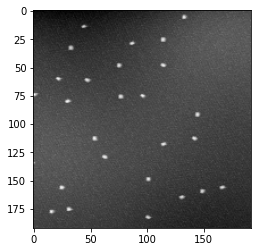

In [52]:
frame_plot_id = 1
plt.imshow(frames[frame_plot_id], cmap='gray');

In [65]:
img_loc_id = 0
molecule_size = 7
min_mass = 1

fs = tp.locate(frames[img_loc_id], molecule_size, minmass=min_mass)
fs.head()

,y,x,mass,size,ecc,orientation,angle,signal,raw_mass,ep
0,4.160290,133.899173,1.907026,1.368315,0.275718,2.834893,2.834893,0.250457,18.034973,0.070871
10,15.731884,43.654244,1.905054,1.468792,0.316684,-2.764251,-2.764251,0.224820,9.990046,0.276840
20,25.751854,115.767672,1.994785,1.414563,0.240939,-3.018212,-3.018212,0.246513,11.892805,0.164066
24,30.656802,88.504154,1.899137,1.503889,0.323023,2.667675,2.667675,0.225806,9.565853,0.326940
27,34.563013,33.468373,2.042115,1.497946,0.188462,2.706815,2.706815,0.235667,8.682756,0.524574


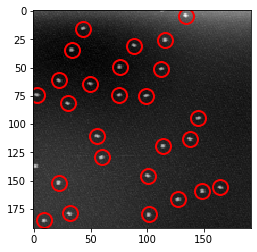

In [66]:
tp.annotate(fs, frames[img_loc_id]);

In [67]:
f = tp.batch(frames, molecule_size, minmass=min_mass)

Frame 14: 26 features


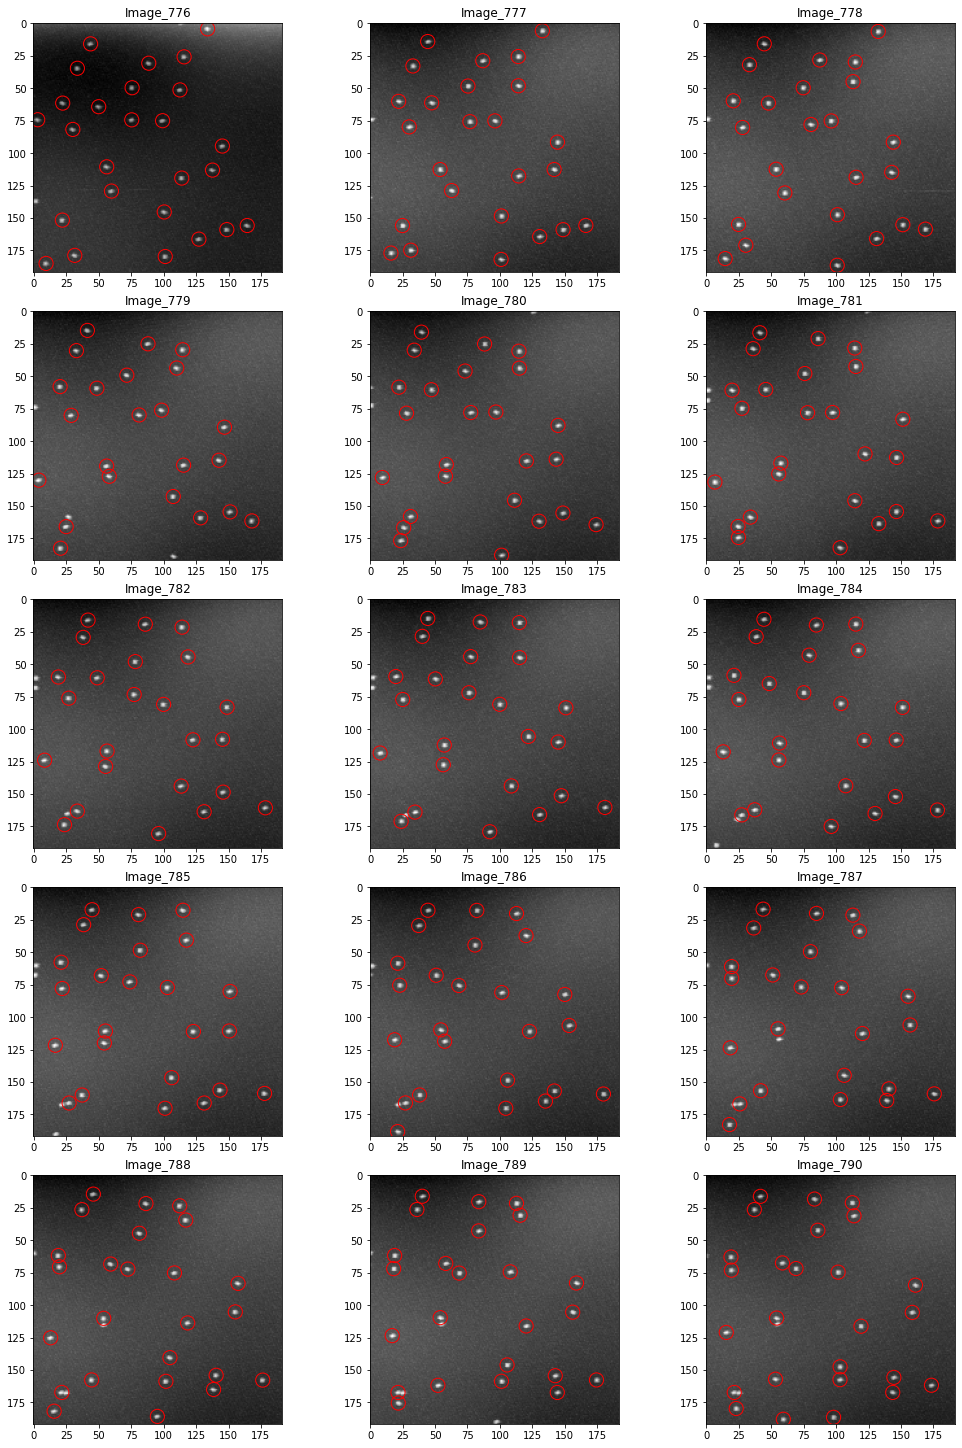

In [68]:
def plot_annotations(fb, images, ncols, figsize=None):
    nrows = len(images) // ncols + (len(images) % ncols > 0)
    plt.figure(figsize=figsize, facecolor='w', constrained_layout=True)
    for n, img in enumerate(images):
        fbn = fb[fb['frame']==n]
        ax = plt.subplot(nrows, ncols, n+1)
        ax.imshow(img, cmap='gray')
        ax.scatter(fbn['x'], fbn['y'], s=200, fc='none', ec='r')
        ax.set(title=f'Image_{setrange[0]+n}')    
    return plt.show()
    
n_cols = 3
plot_annotations(f, frames, n_cols, figsize=(14, 20))

Frame 14: 26 trajectories present.


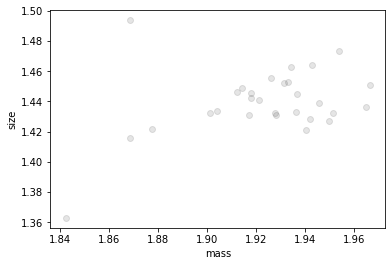

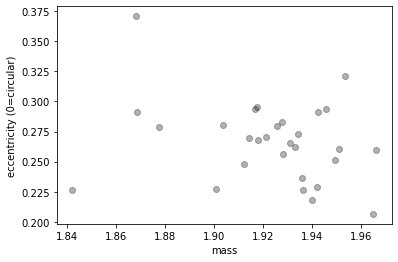

In [69]:
t = tp.link(f, search_range=70, adaptive_stop=5, memory=3)
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

Before: 29
After: 29


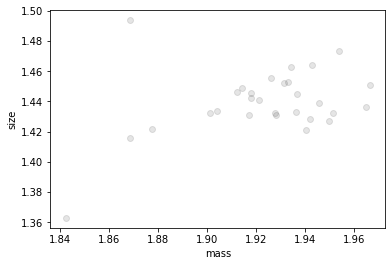

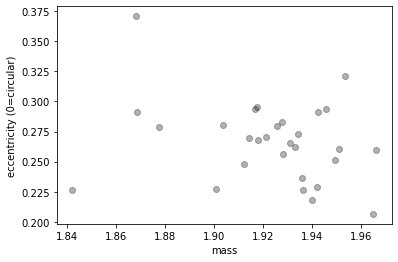

In [70]:
min_mass = 0.01
max_mass = 4.2
min_size = 0.01
max_ecc = 2.5

t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t1, 1)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

tp.mass_size(t2.groupby('particle').mean());
tp.mass_ecc(t2.groupby('particle').mean());

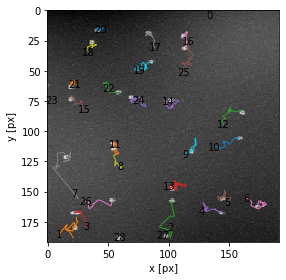

In [71]:
fig, ax = plt.subplots(figsize=None, facecolor='w', tight_layout=True)
tp.plot_traj(t2, superimpose=frames[-1], label=True, ax=ax)
plt.show()

In [61]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
t3=t

In [72]:
t3=t2
# Note: this animation takes a few minutes to process.
def plot_trajectories(traj, images, figsize=None):
    fig, ax = plt.subplots(figsize=figsize, facecolor='w', tight_layout=True)
    ln, = ax.plot([], [], lw=3)
    def animate(i):
        tp.plot_traj(t2[t2['frame'] <= i], superimpose=images[i], label=True, ax=ax)
        for line in ax.lines[:-1]:
            line.set_marker(None)
        return ln,       
    anim = FuncAnimation(fig, animate, frames=len(images), blit=True, interval=400)
    return (HTML(anim.to_jshtml()), plt.close())[0]

plot_trajectories(t3, frames, figsize=None)

bad: []


ValueError: DataFrame of trajectories is empty.

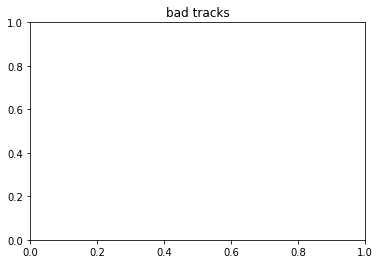

In [50]:
good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
meters_per_pixel = frame_params['meters_per_pixel']
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:] - pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (1e-8/meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
#movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(meters_per_pixel*1e6), superimpose=frames[0]);
im = tp.imsd(tm, meters_per_pixel*1e6, 1)
#im = im.T[movement_filter].T 
# print(im)`

In [ ]:
displacements = np.concatenate(paths)
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
plt.hist(dists, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure();
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
g = sns.jointplot(x="dx", y="dy", data=displacement_df)

In [ ]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
em = tp.emsd(tm, meters_per_pixel*1e6, 1) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));
# fig.savefig('diffusion.png')

In [ ]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]